## **AAI 521 Group 3 Project: Classification of Cat and Dog Images with Background Removal**

**Problem Definition**

The classification of dog and cat images will be one of the problems this program and project will attempt to solve. Additionally, once the classification of the image takes place, image segmentation techniques will be applied to remove the image background while preserving the foreground image of the animal. This problem will employ multiple artificial intelligence techniques. The classification model will use transferred learning of a Convolutional Neural Network (CNN) pre-trained model, and the Grabcut algorithm will be used for background elimination. The problem requires solving for any dog or cat service-related organization, such as a veterinary or animal shelter, where individual pictures of dogs and cats are needed. Using this program, any organization may take photos of any cat or dog in any environment, regardless of background, and provide automatic classification with background removal. Removal of the background eases the identification of the animals within the image.

In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import os
from os import makedirs
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import cv2
import pathlib
import random
from random import random
import math
from os import listdir
from shutil import copyfile
from random import seed # for random number generator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from matplotlib.image import imread
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip folders
#! unzip dogs-vs-cats.zip
! unzip train.zip
! unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

### **EDA and Pre-Processing**

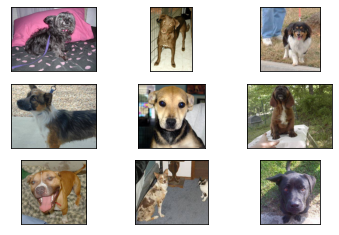

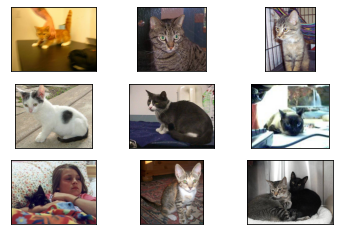

In [ ]:
# plot dog & cats photos from train dataset

# define location of training dataset
folder = '/content/train/'
# plot first 9 images of dogs
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.xticks([])
    plt.yticks([])
    file = folder + 'dog.' + str(i) + '.jpg'
    image = imread(file)
    plt.imshow(image)
plt.show()

# plot first 9 images of cats
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.xticks([])
    plt.yticks([])
    file = folder + 'cat.' + str(i) + '.jpg'
    image = imread(file)
    plt.imshow(image)
plt.show()

In [ ]:
# training dataset size
# assign size
size = 0
 
# assign folder path
folder_path = '/content/train'
 
# get size
for path, dirs, files in os.walk(folder_path):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)
 
# show dataset size
print("Training dataset size: " + str(size) + " Bytes or " + str(size/1000000) + " MB")

Training dataset size: 571915376 Bytes or 571.915376 MB


In [ ]:
# create training & testing subdirectories with dogs & cats labels

dataset_main = 'dogs_vs_cats_train_test/'
subdirectory = ['train/', 'test/']
for subdir in subdirectory:
    label_directory = ['dogs/', 'cats/']
    for labeldir in label_directory:
      directory = dataset_main + subdir + labeldir
      makedirs(directory, exist_ok=True)

In [ ]:
# Splitting images into training & test subdirectories

seed(1) 
train_dir = 'train/' #contains all images
for file in listdir(train_dir):
    source = train_dir + '/' + file
    destination_dir = 'train/'
    if random() < 0.20:       #20% for validation, 80% for training
       destination_dir = 'test/'
    if file.startswith('cat'):
       destination = dataset_main + destination_dir + 'cats/' + file
       copyfile(source, destination) #copying from source to destination
    elif file.startswith('dog'):
        destination = dataset_main + destination_dir + 'dogs/' + file
        copyfile(source, destination)

In [ ]:
# Show number of images within train & test

tr_dogs = os.listdir('/content/dogs_vs_cats_train_test/train/dogs/')
tr_dogs_total = len(tr_dogs)

tr_cats = os.listdir('/content/dogs_vs_cats_train_test/train/cats/')
tr_cats_total = len(tr_cats)

tst_dogs = os.listdir('/content/dogs_vs_cats_train_test/test/dogs/')
tst_dogs_total = len(tst_dogs)

tst_cats = os.listdir('/content/dogs_vs_cats_train_test/test/cats/')
tst_cats_total = len(tst_cats)

print('Number of dog images in train:\n', tr_dogs_total)
print('Number of cats images in train:\n', tr_cats_total)
print('Number of dog images in test:\n', tst_dogs_total)
print('Number of cats images in test:\n', tst_cats_total)
print('Total images in train and test:\n', tr_dogs_total + tr_cats_total + tst_dogs_total + tst_cats_total)

Number of dog images in train:
 9954
Number of cats images in train:
 9956
Number of dog images in test:
 2546
Number of cats images in test:
 2544
Total images in train and test:
 25000


In [ ]:
# Train/test paths
train_path = '/content/dogs_vs_cats_train_test/train/'
test_path = '/content/dogs_vs_cats_train_test/test'

In [ ]:
# Create train/test data generators
data_gen = ImageDataGenerator(featurewise_center=True)

# Imagenet mean values for centering
data_gen.mean = [123.68, 116.779, 103.939] 

# Create train/test iterators
train_it = data_gen.flow_from_directory(train_path, 
                                      class_mode='binary', batch_size=32, target_size=(224, 224))
test_it = data_gen.flow_from_directory(test_path,
                                      class_mode='binary', batch_size=32, target_size=(224, 224))

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


**EDA and Pre-Processing Discussion**

Before applying the images to the deep learning models, the cat and dog datasets were split into test and train sets. 80% of cat and dog images were used for training the models, and 20% of the images were used for validation. During EDA, the dataset classes were plotted to determine how balanced the dataset was; both classes were revealed to be balanced. Since a pre-trained model (VGG16) will be used for transfer learning, the pre-processing of the images requires image scaling, allowing for image centering. This is primarily due to the VGG16 model being previously trained on an ImageNet dataset. The mean pixel values of the ImageNet dataset are used for centering. For testing the classifier, an unseen image will be used with image pre-processing involving making the image into an array, reshaping the image to VGG16 input dimensions (224, 224, 3), and pixel data centering. Furthermore, the image dataset is easily accessible on the Kaggle website.

### **Modeling, Validation, and Performance Metrics**

In [ ]:
# Draw learning curve
def learning_curve(hist):
    # Accuracy curve plot
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    # Loss curve plot
    plt.subplot(2,1,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout() # create vertical space between plot fig
    fig

In [ ]:
# Model 1
# Load pretrained model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 
# Set VGG16 loaded layers to not trainable
for layer in model.layers:
	  layer.trainable = False

# Classifier layers
flat = Flatten()(model.layers[-1].output)

batch_n1 = BatchNormalization()(flat)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(batch_n1) # He_uniform variance scaling initializer
drop1 = Dropout(0.50)(class1) # dropout regularization
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(drop1)
drop2 = Dropout(0.50)(class2)
batch_n2 = BatchNormalization()(drop2)
output = Dense(1, activation='sigmoid')(batch_n2)
 
# Define model inputs and output
model = Model(inputs=model.inputs, outputs=output)
 
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Fit model
hist = model.fit(train_it, validation_data=test_it, epochs=5)

Epoch 1/5
623/623 [==============================] - 158s 235ms/step - loss: 0.1400 - accuracy: 0.9446 - val_loss: 0.0732 - val_accuracy: 0.9699
Epoch 2/5
623/623 [==============================] - 146s 234ms/step - loss: 0.0691 - accuracy: 0.9746 - val_loss: 0.0762 - val_accuracy: 0.9694
Epoch 3/5
623/623 [==============================] - 142s 228ms/step - loss: 0.0527 - accuracy: 0.9807 - val_loss: 0.0745 - val_accuracy: 0.9727
Epoch 4/5
623/623 [==============================] - 151s 243ms/step - loss: 0.0469 - accuracy: 0.9829 - val_loss: 0.0917 - val_accuracy: 0.9682
Epoch 5/5
623/623 [==============================] - 146s 234ms/step - loss: 0.0409 - accuracy: 0.9856 - val_loss: 0.0843 - val_accuracy: 0.9727


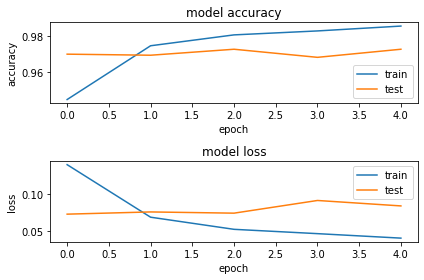

In [ ]:
# Plot learning curves
learning_curve(hist)

In [ ]:
# Evaluate model 
val = model.evaluate(test_it, verbose=1)
print('The model accuracy is:', '%.2f' % (val[1]*100),'%')

160/160 [==============================] - 31s 195ms/step - loss: 0.0843 - accuracy: 0.9727
The model accuracy is: 97.27 %


In [ ]:
# Model 2
# Load pretrained model
model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 
# Set VGG16 loaded layers to not trainable
for layer in model2.layers:
	  layer.trainable = False

# Classifier layers
flat = Flatten()(model2.layers[-1].output)

batch_n1 = BatchNormalization()(flat)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(batch_n1) # He_uniform variance scaling initializer
drop1 = Dropout(0.50)(class1) # dropout regularization
class2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(drop1)
drop2 = Dropout(0.50)(class2)
batch_n2 = BatchNormalization()(drop2)
output = Dense(1, activation='sigmoid')(batch_n2)
 
# Define model inputs and output
model2 = Model(inputs=model2.inputs, outputs=output)
 
# Compile model
opt = SGD(learning_rate=0.001, momentum=0.9) 
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit model
hist = model2.fit(train_it, validation_data=test_it, epochs=5)

Epoch 1/5
623/623 [==============================] - 149s 238ms/step - loss: 0.2144 - accuracy: 0.9078 - val_loss: 0.0830 - val_accuracy: 0.9709
Epoch 2/5
623/623 [==============================] - 145s 233ms/step - loss: 0.1050 - accuracy: 0.9621 - val_loss: 0.0701 - val_accuracy: 0.9733
Epoch 3/5
623/623 [==============================] - 142s 227ms/step - loss: 0.0791 - accuracy: 0.9701 - val_loss: 0.0640 - val_accuracy: 0.9743
Epoch 4/5
623/623 [==============================] - 144s 231ms/step - loss: 0.0657 - accuracy: 0.9753 - val_loss: 0.0615 - val_accuracy: 0.9750
Epoch 5/5
623/623 [==============================] - 144s 231ms/step - loss: 0.0531 - accuracy: 0.9810 - val_loss: 0.0601 - val_accuracy: 0.9756


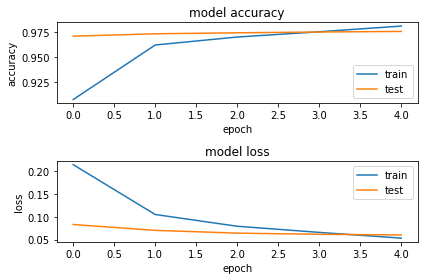

In [ ]:
# Plot learning curves
learning_curve(hist)

In [ ]:
# Evaluate model 
val = model2.evaluate(test_it, verbose=1)
print('The model accuracy is:', '%.2f' % (val[1]*100),'%')

160/160 [==============================] - 29s 179ms/step - loss: 0.0601 - accuracy: 0.9756
The model accuracy is: 97.56 %


In [ ]:
# Model 3 
# Load pretrained model
model3 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 
# Set VGG16 loaded layers to not trainable
for layer in model3.layers:
	  layer.trainable = False

# Classifier layers
flat = Flatten()(model3.layers[-1].output)

batch_n1 = BatchNormalization()(flat)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(batch_n1) # He_uniform variance scaling initializer
drop1 = Dropout(0.50)(class1) # dropout regularization
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(drop1)
drop2 = Dropout(0.50)(class2)
batch_n2 = BatchNormalization()(drop2)
output = Dense(1, activation='sigmoid')(batch_n2)
 
# Define model inputs and output
model3 = Model(inputs=model3.inputs, outputs=output)
 
# Compile model
opt = SGD(learning_rate=0.001, momentum=0.9) 
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit model
hist = model3.fit(train_it, validation_data=test_it, epochs=5)

Epoch 1/5
623/623 [==============================] - 147s 219ms/step - loss: 0.2263 - accuracy: 0.9064 - val_loss: 0.0866 - val_accuracy: 0.9758
Epoch 2/5
623/623 [==============================] - 140s 224ms/step - loss: 0.1145 - accuracy: 0.9566 - val_loss: 0.0686 - val_accuracy: 0.9766
Epoch 3/5
623/623 [==============================] - 136s 218ms/step - loss: 0.0855 - accuracy: 0.9697 - val_loss: 0.0646 - val_accuracy: 0.9774
Epoch 4/5
623/623 [==============================] - 136s 218ms/step - loss: 0.0765 - accuracy: 0.9722 - val_loss: 0.0632 - val_accuracy: 0.9768
Epoch 5/5
623/623 [==============================] - 134s 214ms/step - loss: 0.0607 - accuracy: 0.9776 - val_loss: 0.0620 - val_accuracy: 0.9780


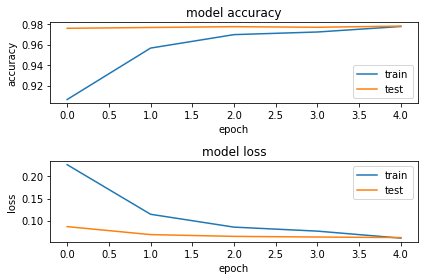

In [ ]:
# Plot learning curves
learning_curve(hist)

In [ ]:
# Evaluate model 
val = model3.evaluate(test_it, verbose=1)
print('The model accuracy is:', '%.2f' % (val[1]*100),'%')

160/160 [==============================] - 27s 170ms/step - loss: 0.0620 - accuracy: 0.9780
The model accuracy is: 97.80 %


**Modeling Results and Findings**

### **Classifying An Unseen Image Using Best Performing Model**

In [ ]:
# Pre-Processing desired dog/cat image

def image_load(file):
	# load image
	image = load_img(file, target_size=(224, 224))
	# array conversion
	image = img_to_array(image)
	# reshape
	image = image.reshape(1, 224, 224, 3)
	# pixel data centering
	image = image.astype('float32')
	image = image - [123.68, 116.779, 103.939] # Imagenet mean values for centering
	return image

1/1 [==============================] - 1s 919ms/step

For the image below, the model predicts a Cat 



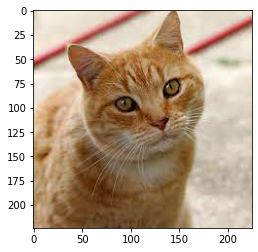

In [ ]:
# Show image & class predicted 

file = 'cat_predict.jpg' # dog_predict.jpg / cat_predict.jpg
img = image_load(file)
prediction = model3.predict(img) # using model #3
print()

# Assign prediction[0] to "Dog" or "Cat" class
if (prediction[0] > 0.5):
    print("For the image below, the model predicts a Dog. \n")
elif (prediction[0] < 0.5): 
    print("For the image below, the model predicts a Cat. \n")

image = imread(file)
plt.imshow(image)
plt.show()

### **Image Segmentation: Eliminating Background**

In [ ]:
# Load and copy image
image_read = cv2.imread(file)
#img = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
img = image_read.copy()

# Make zero filled mask with same image shape
mask = np.zeros(img.shape[:2], np.uint8)

# Image shape
print('Image Shape:', img.shape)

Image Shape: (224, 225, 3)


In [ ]:
# Make zero filled background and foreground models
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

In [ ]:
# Upper left rect corner
x1 = math.floor(0.02*img.shape[1]) 
y1 = math.floor(0.02*img.shape[0])

# Bottom right rect corner
x2 = math.floor(0.98*img.shape[1])
y2 = math.floor(0.98*img.shape[0])

print(y1, x1, x2, y2)

4 4 220 219


In [ ]:
# Make rectangle to isolate object of interest
rect = (y1, x1, x2, y2) # define rectangle

# Apply GrubCut with arguments
cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 7, cv2.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 2, 0],
        [0, 0, 0, ..., 2, 2, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[3.01431262e-01, 1.50357815e-01, 2.73483992e-01, 7.95480226e-02,
         1.95178908e-01, 2.10653880e+02, 2.27332500e+02, 2.34278271e+02,
         1.19227204e+02, 1.54873747e+02, 1.90169088e+02, 1.90746316e+02,
         2.06373915e+02, 2.18107148e+02, 8.90951705e+01, 1.02116951e+02,
         1.73059659e+02, 1.65277499e+02, 1.89421459e+02, 2.09772096e+02,
         8.24317440e+01, 6.50854712e+01, 6.56534812e+01, 6.50854712e+01,
         5.78288413e+01, 5.52852083e+01, 6.56534812e+01, 5.52852083e+01,
         6.02648121e+01, 8.56241214e+02, 5.61572523e+02, 5.52201813e+02,
         5.61572523e+02, 4.22133359e+02, 4.34675656e+02, 5.52201813e+02,
         4.34675656e+02, 5.15930077e+02, 1.04246345e+02, 1.00122401e+02,
         1.11728462e+02, 1.00122401e+02, 1.0

In [ ]:
# Define second mask (keeps foreground object, darkens background)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Apply mask2 to image
img = img*mask2[:,:,np.newaxis]

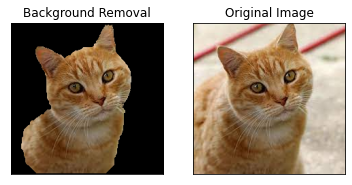

In [ ]:
# Plot images
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Background Removal')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.show()